In [1]:
import pandas as pd
import numpy as np
import itertools as it
import os
import io
import logging

import boto3
import sys
import json
import snowflake.connector

# Reading Data 

In [2]:
input_bucket = "hbo-ingest-datascience-content-dev"

In [3]:
logger = logging.getLogger()
logger.info(f'Loading inputs')
data_list =[]

s3 = boto3.resource('s3')
bucket = s3.Bucket(input_bucket)

for obj in bucket.objects.filter(Prefix='cost_allocation/dev/churn_metric_0906'): #churn_metric_0811
            key = obj.key
            logger.info('Loading csv file {}'.format(key))
            body = obj.get()['Body']
            print('Reading {0} features'.format(key))
            churn_metric = pd.read_csv(body, na_values = [r'\\\\N'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


Reading cost_allocation/dev/churn_metric_0906.csv features


In [4]:
churn_metric.head()

,Unnamed: 0,genre,medal,category,churn_per_hr_person
0,0,action,Platinum,movies,-0.028358
1,1,action,Gold,series,-0.020530
2,2,action,Gold,movies,-0.027117
3,3,action,Silver,series,-0.005406
4,4,action,Silver,movies,-0.019190


In [5]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [6]:
# hours_viewed = run_query('''SELECT * FROM max_dev.workspace.user_title_hours_watched_crossvalidation''')

In [7]:
hours_viewed = pd.read_csv('validation_data.csv')

In [8]:
hours_viewed.head()

,Unnamed: 0,title_name,title_id,season_number,days_on_hbo_max,cumulative_hours_viewed,average_hours_viewed,offering_start_date,asset_run_time_hours,content_category,...,genre_Kids/Family.2,genre_Music.2,genre_Other.2,genre_Romance.2,genre_Sci-Fi.2,genre_Suspense/Thriller.2,genre_Unscripted.2,hvr,ahvr,content_cost
0,0,VICE Special Report: Killing Cancer,GV-54_wnG7qbCwwEAAAAY,0,60,64.627222,0.000049,2020-05-27,0.640000,movies,...,0,0,0,0,0,0,0,100.980035,0.000077,NaN
1,1,VICE Special Report: Countdown to Zero,GV-55HghKlqbCwwEAAAAb,0,60,32.569444,0.000025,2020-05-27,0.809722,movies,...,0,0,0,0,0,0,0,40.222996,0.000031,NaN
2,2,VICE Special Report: Fixing the System,GV-55Hwvj4IaDwwEAAAAY,0,60,139.329722,0.000106,2020-05-27,1.108055,movies,...,0,0,0,0,0,0,0,125.742605,0.000095,NaN
3,3,VICE Special Report: Fighting ISIS,GV-55JASHjruwgwEAAAAU,0,60,163.436389,0.000124,2020-05-27,0.786388,movies,...,0,0,0,0,0,0,0,207.831743,0.000158,NaN
4,4,Heartbreakers,GV-BGJA11hsLDwwEAAAAZ,0,60,11945.052500,0.003908,2020-09-01,2.057777,movies,...,0,0,0,0,0,0,0,5804.833323,0.001899,259000.0


In [9]:
hours_viewed = hours_viewed[['title_name', 'title_id', 'season_number', 'offering_start_date' , 'ahvr', 'pillar_genre', 'medal', 'content_category']]

In [10]:
hours_viewed.rename(columns = {'ahvr':'average_hours_viewed_60d', 'pillar_genre': 'genre', 'content_category':'category'}, inplace = True)

In [11]:
hours_viewed.category.unique()

array(['movies', 'series', 'special', nan, 'livesports'], dtype=object)

In [12]:
churn_metric.category.unique()

array(['movies', 'series'], dtype=object)

In [13]:
hours_viewed.loc[hours_viewed['genre'] == 'Action/Adventure ', 'genre'] = 'action'
hours_viewed.loc[hours_viewed['genre'] == 'Comedy', 'genre'] = 'comedy'
hours_viewed.loc[hours_viewed['genre'] == 'Drama', 'genre'] = 'drama'
hours_viewed.loc[~hours_viewed['genre'].isin(['action', 'comedy', 'drama']), 'genre'] = 'other'

hours_viewed.loc[hours_viewed['medal'] == 'None', 'medal'] = 'Bronze'

hours_viewed.loc[hours_viewed['category'] == 'special', 'category'] = 'movies'

In [14]:
hours_viewed = hours_viewed.merge(churn_metric[['genre','medal','category', 'churn_per_hr_person']], on = ['genre','medal','category'])

In [15]:
hours_viewed['change_in_churn_60d'] = hours_viewed['average_hours_viewed_60d'] * hours_viewed['churn_per_hr_person']

In [16]:
hours_viewed_thresh = hours_viewed[hours_viewed['average_hours_viewed_60d'] >= 0.015]

In [17]:
churn_metric.head()

,Unnamed: 0,genre,medal,category,churn_per_hr_person
0,0,action,Platinum,movies,-0.028358
1,1,action,Gold,series,-0.020530
2,2,action,Gold,movies,-0.027117
3,3,action,Silver,series,-0.005406
4,4,action,Silver,movies,-0.019190


# Allocate the 60-Day Churn to monthly

## First 60 Allocation

In [18]:
dt_df = pd.DataFrame()
dt_df['days_on_hbo_max'] = [i for i in range(0, 60, 1)]

In [19]:
hours_viewed_thresh['key'] = 1
dt_df['key'] = 1

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [20]:
hours_viewed_60d = hours_viewed_thresh.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

hours_viewed_60d['request_date'] = pd.to_datetime(hours_viewed_60d['offering_start_date']) \
                                    + pd.to_timedelta(hours_viewed_60d['days_on_hbo_max'], unit='D')

hours_viewed_60d['change_in_churn'] = hours_viewed_60d['change_in_churn_60d']/60

## After 60 Day Allocation

In [21]:
ever_green_titles = pd.read_csv('ever_green_titles.csv')

In [22]:
ever_green_titles.head()

,Unnamed: 0,title_name,title_id,season_number,match_id,offering_start_date,ahvr,ahvr_90
0,5892,Injustice,GYbvoqgoeYawYwwEAAAAN,0,GYbvoqgoeYawYwwEAAAAN,2022-01-17,0.236977,0.593506
1,5249,Red 2,GYOjdCwdKNsI-wgEAAAZc,0,GYOjdCwdKNsI-wgEAAAZc,2022-02-01,0.027843,0.052037
2,3698,Misery,GXrHsBAPxLomBSgEAAAB4,0,GXrHsBAPxLomBSgEAAAB4,2020-06-01,0.018080,0.027320
3,3296,Ella Enchanted,GXoTAXgmV2ZCtwwEAAACI,0,GXoTAXgmV2ZCtwwEAAACI,2020-05-27,0.017993,0.026021
4,3198,The Hangover Part II,GXnjwZgr15aFYqQEAAAbj,0,GXnjwZgr15aFYqQEAAAbj,2020-05-27,0.029151,0.045031


In [23]:
len(ever_green_titles.title_id.unique())

62

In [24]:
len(hours_viewed_thresh.title_id.unique())

753

In [25]:
ever_green_titles.sort_values(by = ['title_name']).title_name.unique()

array(['2 Fast 2 Furious', 'Along Came Polly', 'American Pie',
       'American Psycho', 'Annabelle Comes Home', 'Bad Education',
       'Batman: Assault on Arkham', 'Batman: Under the Red Hood',
       'Big Little Lies', 'Contraband', 'Cowboys & Aliens',
       'Curb Your Enthusiasm', 'Downton Abbey',
       "Dr. Seuss' How the Grinch Stole Christmas", 'Ella Enchanted',
       'Euphoria', 'Fight Club', 'Friday After Next', 'Friends',
       'Full Metal Jacket', 'G.I. Joe: The Rise of Cobra',
       'Game of Thrones', 'Godzilla: King of the Monsters', 'Good Boys',
       'Hall Pass', 'How to Lose a Guy in 10 Days',
       'Ice Age: Continental Drift', 'Injustice',
       'Justice League Dark: Apokolips War',
       'Justice League vs the Fatal Five',
       'Justice League vs. Teen Titans',
       'Justice League: Crisis on Two Earths', 'Justice League: Doom',
       'Justice League: Gods and Monsters',
       'Justice League: The Flashpoint Paradox',
       'Justice League: Throne of 

In [26]:
ever_green_title_id = ever_green_titles.title_id.unique()

In [27]:
norm_title_id = hours_viewed_thresh[~hours_viewed_thresh['title_id'].isin(ever_green_title_id)].title_id.unique()

### 1. Normal Titles

In [28]:
from scipy.optimize import curve_fit

In [29]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

Matplotlib is building the font cache; this may take a moment.


In [30]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

## 90% of the retention value deteriorates in the first year
x = [0, 0.8, 5]
y = [1, 0.1, 0.0001]

popt, pcov = curve_fit(func, x, y)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [31]:
x1 = pd.Series(np.arange(0,5,0.1))
y1 = func(x1, *popt)

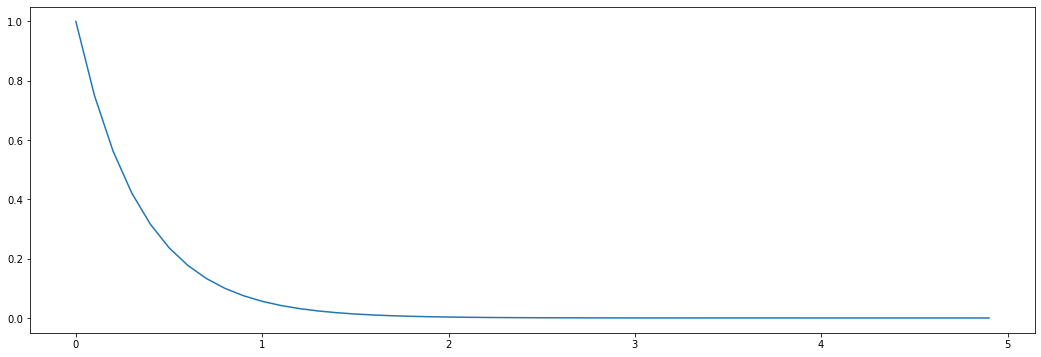

In [32]:
fig, ax = plt.subplots(figsize=(18, 6))
plt.plot(x1, y1)
plt.show()

In [33]:
dt_df = pd.DataFrame()
dt_df['days_on_hbo_max'] = [i for i in range(0, 365, 1)]
dt_df['factor'] = func(dt_df['days_on_hbo_max']/365, *popt)
dt_df['key'] = 1

In [34]:
hours_viewed_decay_norm = hours_viewed_thresh[hours_viewed_thresh['title_id'].isin(norm_title_id)]

hours_viewed_decay_norm = hours_viewed_decay_norm.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

hours_viewed_decay_norm['change_in_churn'] = hours_viewed_decay_norm['change_in_churn_60d']/60*hours_viewed_decay_norm['factor']

hours_viewed_decay_norm['days_on_hbo_max'] = hours_viewed_decay_norm['days_on_hbo_max']+60

hours_viewed_decay_norm['request_date'] = pd.to_datetime(hours_viewed_decay_norm['offering_start_date']) \
                                        + pd.to_timedelta(hours_viewed_decay_norm['days_on_hbo_max'], unit='D')

hours_viewed_decay_norm = hours_viewed_decay_norm[hours_viewed_decay_norm['request_date'] <= '2023-03-01']


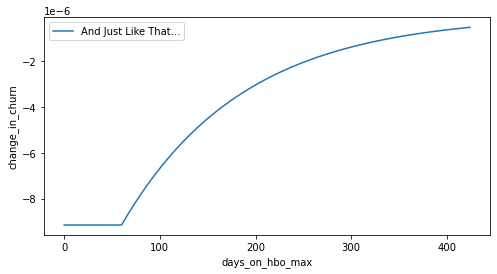

In [35]:
fig, ax = plt.subplots(figsize=(8, 4))
test = pd.concat([hours_viewed_60d[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']],
                hours_viewed_decay_norm[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max','change_in_churn']]],
                axis = 0)
plot_df = test[test['title_name'] == 'And Just Like That...']
plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label='And Just Like That...')

ax.set_xlabel('days_on_hbo_max')
ax.set_ylabel('change_in_churn')
ax.legend()

plt.show()

### 2. Evergreen Titles

#### 2.1 Sogmoid Decay

In [36]:
# ## 90% of the retention value is deteriorated in the first year
# x = [0, 0.25, 1.5, 3]
# y = [1, 0.99, 0.5, 0.001]

# def sigmoid(x, L ,x0, k, b):
#     y = L / (1 + np.exp(-k*(x-x0))) + b
#     return (y)

# p0 = [max(y), np.median(x),1,min(y)] # this is an mandatory initial guess

# popt, pcov = curve_fit(sigmoid, x, y ,p0, method='dogbox')

# x1 = pd.Series(np.arange(0,5,0.1))
# y1 = sigmoid(x1, *popt)

# fig, ax = plt.subplots(figsize=(18, 6))
# plt.plot(x1, y1)
# plt.show()

In [37]:
# dt_df = pd.DataFrame()
# dt_df['days_on_hbo_max'] = [i for i in range(0, 365*3, 1)]
# dt_df['factor'] = sigmoid(dt_df['days_on_hbo_max']/365, *popt)
# dt_df['key'] = 1

# hours_viewed_decay_evergreen = hours_viewed_thresh[hours_viewed_thresh['title_id'].isin(ever_green_title_id)]

# hours_viewed_decay_evergreen = hours_viewed_decay_evergreen.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

# hours_viewed_decay_evergreen['change_in_churn'] = hours_viewed_decay_evergreen['change_in_churn_60d']/60*hours_viewed_decay_evergreen['factor']

# hours_viewed_decay_evergreen['days_on_hbo_max'] = hours_viewed_decay_evergreen['days_on_hbo_max']+60

# hours_viewed_decay_evergreen['request_date'] = pd.to_datetime(hours_viewed_decay_evergreen['offering_start_date']) \
#                                         + pd.to_timedelta(hours_viewed_decay_evergreen['days_on_hbo_max'], unit='D')

# hours_viewed_decay_evergreen = hours_viewed_decay_evergreen[hours_viewed_decay_evergreen['request_date'] <= '2023-03-01']


In [38]:
# fig, ax = plt.subplots(figsize=(8, 4))
# test = pd.concat([hours_viewed_60d[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']],
#                 hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']]],
#                 axis = 0)


# for i in range(1, 11, 1):
#     plot_df = test[(test['title_name'] == 'Friends') &(test['season_number'] == i)]
#     plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label= 'Friends S' + str(i))

# ax.set_xlabel('days_on_hbo_max')
# ax.set_ylabel('change_in_churn')
# ax.legend()

# plt.show()

#### 2.2 Keep the retention value all the way along

In [39]:
dt_df = pd.DataFrame()
dt_df['days_on_hbo_max'] = [i for i in range(0, 365*3, 1)]
dt_df['key'] = 1

hours_viewed_decay_evergreen = hours_viewed_thresh[hours_viewed_thresh['title_id'].isin(ever_green_title_id)]

hours_viewed_decay_evergreen = hours_viewed_decay_evergreen.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

hours_viewed_decay_evergreen['change_in_churn'] = hours_viewed_decay_evergreen['change_in_churn_60d']/60

hours_viewed_decay_evergreen['days_on_hbo_max'] = hours_viewed_decay_evergreen['days_on_hbo_max']+60

hours_viewed_decay_evergreen['request_date'] = pd.to_datetime(hours_viewed_decay_evergreen['offering_start_date']) \
                                        + pd.to_timedelta(hours_viewed_decay_evergreen['days_on_hbo_max'], unit='D')

hours_viewed_decay_evergreen = hours_viewed_decay_evergreen[hours_viewed_decay_evergreen['request_date'] <= '2023-03-01']


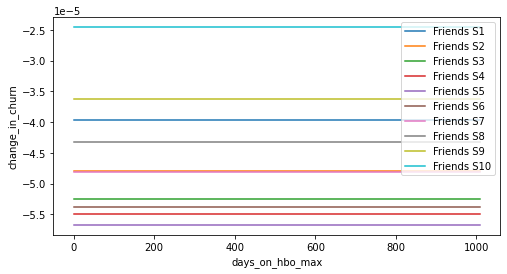

In [40]:
fig, ax = plt.subplots(figsize=(8, 4))
test = pd.concat([hours_viewed_60d[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']],
                hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']]],
                axis = 0)


for i in range(1, 11, 1):
    plot_df = test[(test['title_name'] == 'Friends') &(test['season_number'] == i)]
    plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label= 'Friends S' + str(i))

ax.set_xlabel('days_on_hbo_max')
ax.set_ylabel('change_in_churn')
ax.legend()

plt.show()

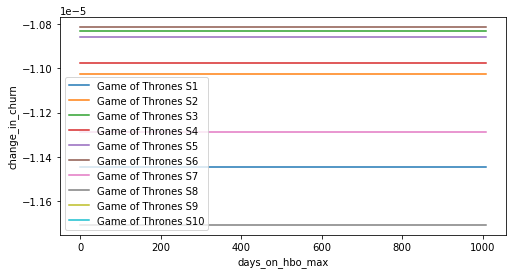

In [41]:
fig, ax = plt.subplots(figsize=(8, 4))
test = pd.concat([hours_viewed_60d[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']],
                hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']]],
                axis = 0)


for i in range(1, 11, 1):
    plot_df = test[(test['title_name'] == 'Game of Thrones') &(test['season_number'] == i)]
    plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label= 'Game of Thrones S' + str(i))

ax.set_xlabel('days_on_hbo_max')
ax.set_ylabel('change_in_churn')
ax.legend()

plt.show()

## UNION ALL THE DFs

In [42]:
data = pd.concat([hours_viewed_60d[['title_name', 'title_id', 'season_number', 'genre', 'medal', 'offering_start_date', 'request_date', 'days_on_hbo_max', 'change_in_churn']],
                hours_viewed_decay_norm[['title_name', 'title_id', 'season_number', 'genre', 'medal', 'offering_start_date', 'request_date',  'days_on_hbo_max', 'change_in_churn']],
                hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'genre', 'medal', 'offering_start_date', 'request_date',  'days_on_hbo_max', 'change_in_churn']] ],
                axis = 0)

In [43]:
data['date_month'] = data['request_date'].dt.to_period('M')

In [44]:
# data.groupby(['date_month']).change_in_churn.sum().reset_index().sort_values(by = ['date_month'])

In [45]:
data[data['date_month'] == '2022-09'].groupby(['title_name', 'title_id', 'season_number']).sum().reset_index()\
.sort_values(by = ['change_in_churn']).head(20)

,title_name,title_id,season_number,days_on_hbo_max,change_in_churn
61,Euphoria,GXKN_xQX5csPDwwEAAABj,2,7455,-0.008255
104,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,0,7725,-0.004989
110,House of the Dragon,GYsYeoAxKH8LCwgEAAAOR,1,735,-0.004590
220,The Batman,GYiDbSAmIpMNvYAEAAAAI,0,4515,-0.004417
70,Free Guy,GYdYmPQZFO7eZGAEAAAAT,0,6135,-0.004075
248,The King's Man,GYeGXugg4ewPCwgEAABi1,0,6285,-0.003900
114,Injustice,GYbvoqgoeYawYwwEAAAAN,0,7245,-0.002561
133,Kong: Skull Island,GX-nzMwc-EaCFpgEAAAMh,0,18675,-0.002534
106,Hitman's Wife's Bodyguard,GYabfeQrMwLqFugEAAAAC,0,7545,-0.002515
249,The Last Duel,GYbzvWABDj8LDwgEAAAAp,0,7335,-0.002417


In [46]:
# data[(data['request_date'] == '2023-03-01')
#     &(data['title_name'] == 'Friends')].sort_values(by = ['change_in_churn']).head(20)

# Correlation with Change in Churn

## 1. Correlation with Churn itself

In [124]:
churn_genpop = run_query('''
select
     dt.start_date as date_month,
    COUNT(DISTINCT CASE WHEN is_cancel = TRUE THEN up.hbo_uuid ELSE NULL END) as churns,
    COUNT(DISTINCT up.hbo_uuid) as total_subs,
    churns/total_subs as churn_rate
from MAX_PROD.CONTENT_ANALYTICS.CALENDAR_DATE_TRACKER dt
JOIN max_prod.identity.user_profile_dim_current up 
JOIN max_dev.workspace.user_retain_churn_list_test as c 
    on c.hurley_user_id = up.hurley_user_id
    and c.cycle_expire_date BETWEEN START_DATE and END_DATE
WHERE 1=1
AND up.is_primary_profile=1
AND dt.end_date = DATEADD('DAY', -1, (DATEADD('MONTH', 1, dt.start_date)))
AND dt.start_date = DATE_TRUNC('MONTH', dt.start_date)
and dt.start_date < '2023-03-01'
and SUB_MONTH <=24
--and SUB_MONTH >1
group by 1
order by 1
''')

In [ ]:
churn_genpop_tenure = run_query('''
select
     dt.start_date as date_month, sub_month as tenure,
    COUNT(DISTINCT CASE WHEN is_cancel = TRUE THEN up.hbo_uuid ELSE NULL END) as churns,
    COUNT(DISTINCT up.hbo_uuid) as total_subs,
    churns/total_subs as churn_rate
from MAX_PROD.CONTENT_ANALYTICS.CALENDAR_DATE_TRACKER dt
JOIN max_prod.identity.user_profile_dim_current up 
JOIN max_dev.workspace.user_retain_churn_list_test as c 
    on c.hurley_user_id = up.hurley_user_id
    and c.cycle_expire_date BETWEEN START_DATE and END_DATE
WHERE 1=1
AND up.is_primary_profile=1
AND dt.end_date = DATEADD('DAY', -1, (DATEADD('MONTH', 1, dt.start_date)))
AND dt.start_date = DATE_TRUNC('MONTH', dt.start_date)
and dt.start_date < '2023-03-01'
and SUB_MONTH <=24
group by 1, 2
order by 1, 2
''')

In [ ]:
churn_exclude_t1 = run_query('''
select
     dt.start_date as date_month,
    COUNT(DISTINCT CASE WHEN is_cancel = TRUE THEN up.hbo_uuid ELSE NULL END) as churns,
    COUNT(DISTINCT up.hbo_uuid) as total_subs,
    churns/total_subs as churn_rate
from MAX_PROD.CONTENT_ANALYTICS.CALENDAR_DATE_TRACKER dt
JOIN max_prod.identity.user_profile_dim_current up 
JOIN max_dev.workspace.user_retain_churn_list_test as c 
    on c.hurley_user_id = up.hurley_user_id
    and c.cycle_expire_date BETWEEN START_DATE and END_DATE
WHERE 1=1
AND up.is_primary_profile=1
AND dt.end_date = DATEADD('DAY', -1, (DATEADD('MONTH', 1, dt.start_date)))
AND dt.start_date = DATE_TRUNC('MONTH', dt.start_date)
and dt.start_date < '2023-03-01'
AND SUB_MONTH > 1
group by 1
order by 1
''')

In [78]:
churn_genpop.head()

,date_month,churns,total_subs,churn_rate
0,2020-06-01,9,84,0.107143
1,2020-07-01,2125,31493,0.067475
2,2020-08-01,77090,794407,0.097041
3,2020-09-01,92234,1014273,0.090936
4,2020-10-01,107861,1230141,0.087682


In [125]:
# churn_genpop_tenure[churn_genpop_tenure['date_month'].astype(str) == '2023-02-01']

In [126]:
aggregated_churn = data.groupby(['date_month'])['change_in_churn'].sum().reset_index()
aggregated_churn['date_month'] = aggregated_churn['date_month'].dt.to_timestamp().dt.strftime('%Y-%m-%d')

#### GENPOP ONLY LOOKS AT 2022-01-01 ON-WARDS ###################################
aggregated_churn = aggregated_churn[aggregated_churn['date_month']>='2021-12-01']

#### Shift one month forward
# aggregated_churn['date_month']  = (pd.to_datetime(aggregated_churn['date_month']) + pd.DateOffset(months=1)).dt.strftime('%Y-%m-%d')

In [127]:
churn_genpop_tenure_pivot = pd.pivot_table(churn_genpop_tenure, values='churn_rate', index=['date_month'],
                       columns=['tenure'], fill_value=0, aggfunc='first').reset_index()

In [128]:
churn_all = churn_genpop_tenure_pivot.merge(churn_genpop[['date_month', 'churn_rate']].rename(columns = {'churn_rate':'genpop_churn'}),
                                           on = ['date_month'])\
                                    .merge(churn_exclude_t1[['date_month', 'churn_rate']].rename(columns = {'churn_rate':'churn_exclude_t1'}),
                                          on = ['date_month'])

In [129]:
churn_all['date_month'] = churn_all['date_month'].astype(str)

In [130]:
churn_all.head()

,date_month,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,genpop_churn,churn_exclude_t1
0,2020-06-01,0.081925,0.416667,0.059701,0.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.082013,0.107143
1,2020-07-01,0.147216,0.067450,0.125000,0.030769,0.000000,0.000000,0,0,0.500000,...,0,0,0,0,0.000000,0,0,0,0.144546,0.067473
2,2020-08-01,0.246896,0.098401,0.061422,0.068966,0.046875,0.000000,0.000000,0,0.000000,...,0.000000,0,0,0,0,0.000000,0,0,0.150222,0.097041
3,2020-09-01,0.266349,0.131667,0.073671,0.047285,0.640000,0.949153,0.000000,0.000000,0,...,0.000000,0.000000,0,0,0,0,0.000000,0,0.138151,0.090936
4,2020-10-01,0.232411,0.143210,0.101009,0.059563,0.040794,0.090909,0.000000,0.000000,0.000000,...,0.000000,0.500000,0.000000,0,0,0,0,0.000000,0.134923,0.087682


In [131]:
churn_all = churn_all.merge(aggregated_churn, on = ['date_month'])

In [132]:
TARGET_COL = ['change_in_churn']
FEATURE_COLS = [i for i in range(1, 25)]+['genpop_churn', 'churn_exclude_t1']

In [133]:
for i in FEATURE_COLS:
    churn_all[i] = churn_all[i].astype(float)

In [134]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [135]:
plot_data=churn_all[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
# corr.sort_values(by = TARGET_COL)
# 0.819
corr

,change_in_churn
1,-0.152605
2,-0.033025
3,0.091534
4,0.543658
5,0.677598
6,0.586760
7,0.578258
8,0.562337
9,0.436913
10,0.243082


<AxesSubplot:>

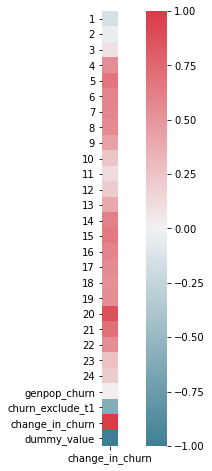

In [136]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

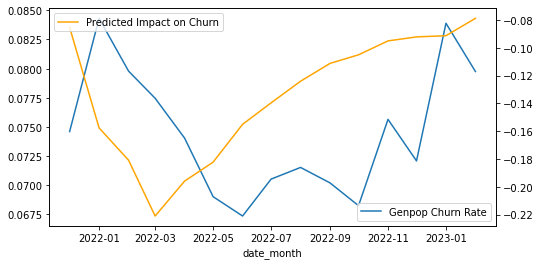

In [137]:
fig, ax = plt.subplots(figsize=(8, 4))

plot_df = churn_all
plot_df['date_month'] = pd.to_datetime(plot_df['date_month'])
ax.plot(plot_df['date_month'], plot_df['genpop_churn'], label= 'Genpop Churn Rate')

ax2 = ax.twinx()
ax2.plot(plot_df['date_month'], plot_df['change_in_churn'], label= 'Predicted Impact on Churn', color = 'orange')

ax.set_xlabel('date_month')
ax.legend(loc = 'lower right')
ax2.legend(loc = 'upper left')

plt.show()

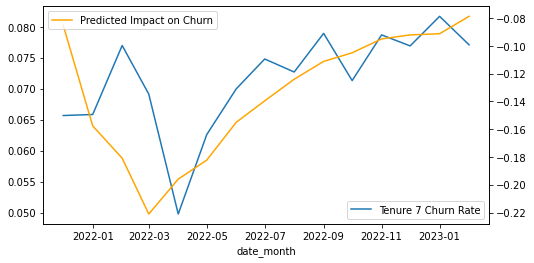

In [138]:
fig, ax = plt.subplots(figsize=(8, 4))

plot_df = churn_all
plot_df['date_month'] = pd.to_datetime(plot_df['date_month'])
ax.plot(plot_df['date_month'], plot_df[7], label= 'Tenure 7 Churn Rate')

ax2 = ax.twinx()
ax2.plot(plot_df['date_month'], plot_df['change_in_churn'], label= 'Predicted Impact on Churn', color = 'orange')

ax.set_xlabel('date_month')
ax.legend(loc = 'lower right')
ax2.legend(loc = 'upper left')

plt.show()

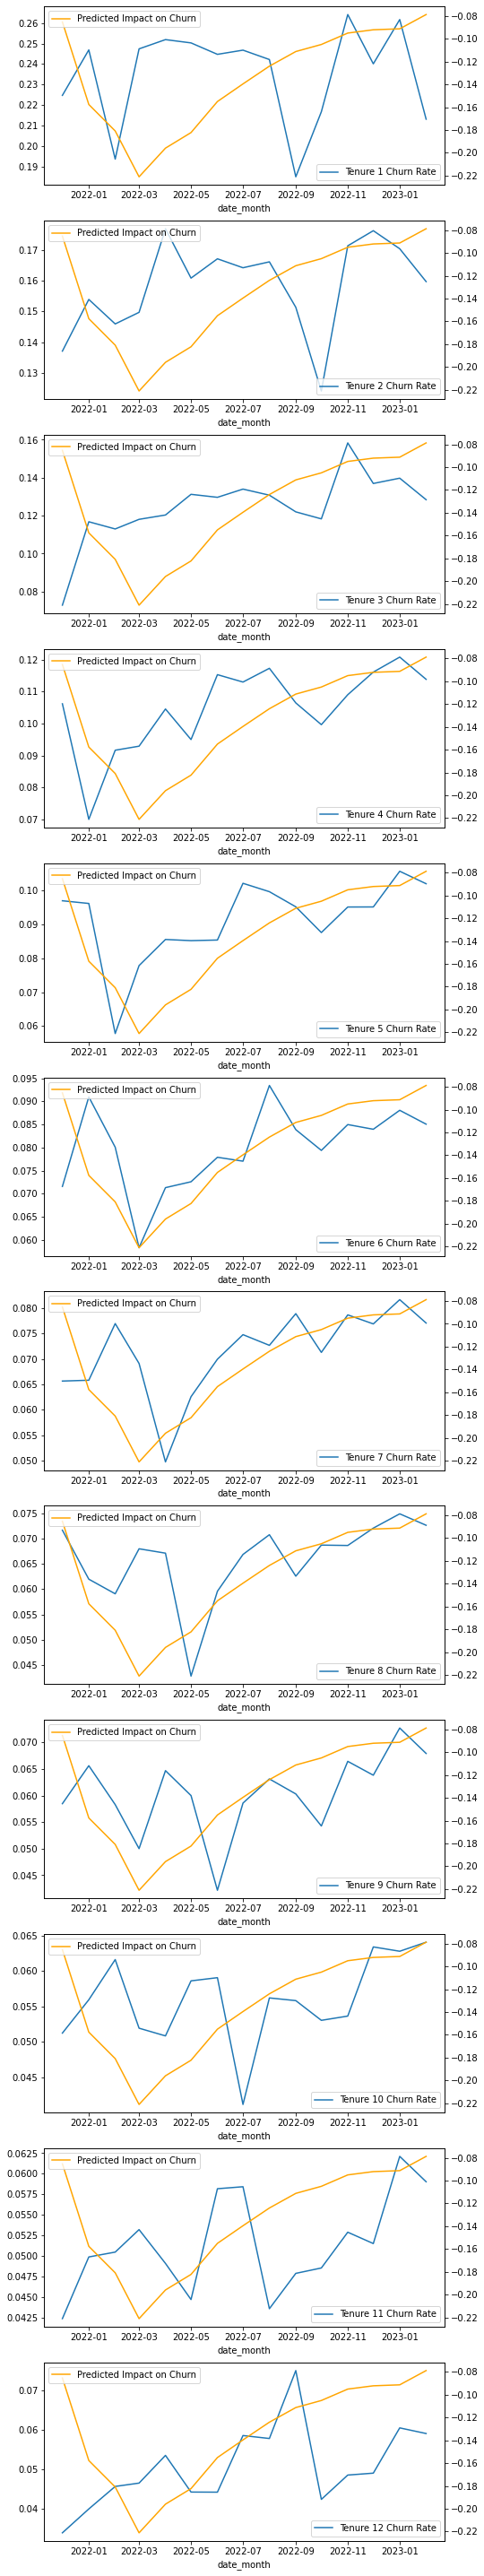

In [139]:
# fig, ax = plt.subplots(figsize=(8, 4))
plot_df = churn_all
plot_df['date_month'] = pd.to_datetime(plot_df['date_month'])
fig, ax = plt.subplots(12,1,figsize=(8, 52))

for i in range(0, 12, 1):
    ax1 = ax[i]
    ax1.plot(plot_df['date_month'], plot_df[i+1], label= 'Tenure ' + str(i+1)+ ' Churn Rate')

    ax2 = ax[i].twinx()
    ax2.plot(plot_df['date_month'], plot_df['change_in_churn'], label= 'Predicted Impact on Churn', color = 'orange')

    ax1.set_xlabel('date_month')
    ax1.legend(loc = 'lower right')
    ax2.legend(loc = 'upper left')

plt.show()
    

## 2. Correlation with Tenure Buckets

In [108]:
churn_genpop_tenure_bucekts = run_query('''
select
     dt.start_date as date_month, 
     case when sub_month <=3 then '1-3'
          when sub_month <=6 then '4-6'
          when sub_month <=12 then '7-12'
          when sub_month <=24 then '13-24'
          when sub_month <=36 then '25-36'
          else '36+'
     end as tenure,
    COUNT(DISTINCT CASE WHEN is_cancel = TRUE THEN up.hbo_uuid ELSE NULL END) as churns,
    COUNT(DISTINCT up.hbo_uuid) as total_subs,
    churns/total_subs as churn_rate
from MAX_PROD.CONTENT_ANALYTICS.CALENDAR_DATE_TRACKER dt
JOIN max_prod.identity.user_profile_dim_current up 
JOIN max_dev.workspace.user_retain_churn_list_test as c 
    on c.hurley_user_id = up.hurley_user_id
    and c.cycle_expire_date BETWEEN START_DATE and END_DATE
WHERE 1=1
AND up.is_primary_profile=1
AND dt.end_date = DATEADD('DAY', -1, (DATEADD('MONTH', 1, dt.start_date)))
AND dt.start_date = DATE_TRUNC('MONTH', dt.start_date)
and dt.start_date < '2023-03-01'
--and SUB_MONTH <=24
group by 1, 2
order by 1, 2
''')

In [109]:
churn_genpop_tenure_bucekts_pivot = pd.pivot_table(churn_genpop_tenure_bucekts, values='churn_rate', index=['date_month'],
                       columns=['tenure'], fill_value=0, aggfunc='first').reset_index()

In [110]:
churn_bucekts_all = churn_genpop_tenure_bucekts_pivot.merge(churn_genpop[['date_month', 'churn_rate']].rename(columns = {'churn_rate':'genpop_churn'}),
                                           on = ['date_month'])\
                                    .merge(churn_exclude_t1[['date_month', 'churn_rate']].rename(columns = {'churn_rate':'churn_exclude_t1'}),
                                          on = ['date_month'])

In [111]:
churn_bucekts_all['date_month'] = churn_bucekts_all['date_month'].astype(str)

In [112]:
churn_bucekts_all = churn_bucekts_all.merge(aggregated_churn, on = ['date_month'])

In [113]:
churn_bucekts_all.head()

,date_month,1-3,13-24,25-36,36+,4-6,7-12,genpop_churn,churn_exclude_t1,change_in_churn
0,2021-12-01,0.138772,0.026163,0.021732,0.030303,0.090486,0.054084,0.062787,0.062775,-0.085270
1,2022-01-01,0.191762,0.027711,0.028538,0.014925,0.081849,0.057722,0.063140,0.063128,-0.157648
2,2022-02-01,0.164485,0.031045,0.021894,0.014925,0.072944,0.058322,0.063184,0.063168,-0.180878
3,2022-03-01,0.170197,0.027813,0.027443,0.024390,0.072797,0.054829,0.063757,0.063743,-0.221082
4,2022-04-01,0.172488,0.029994,0.028503,0.033708,0.090079,0.054364,0.063942,0.063927,-0.195944


In [118]:
TARGET_COL = ['change_in_churn']
FEATURE_COLS = ['1-3', '4-6', '7-12', '13-24','25-36','36+', 'genpop_churn']

In [119]:
FEATURE_COLS

['1-3', '4-6', '7-12', '13-24', '25-36', '36+', 'genpop_churn']

In [120]:
for i in FEATURE_COLS:
    churn_bucekts_all[i] = churn_bucekts_all[i].astype(float)

In [121]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [122]:
plot_data=churn_bucekts_all[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
# corr.sort_values(by = TARGET_COL)
# 0.819
corr

,change_in_churn
1-3,0.026587
4-6,0.754789
7-12,0.600341
13-24,0.617366
25-36,-0.499007
36+,0.053795
genpop_churn,0.177920
change_in_churn,1.000000
dummy_value,-1.000000


<AxesSubplot:>

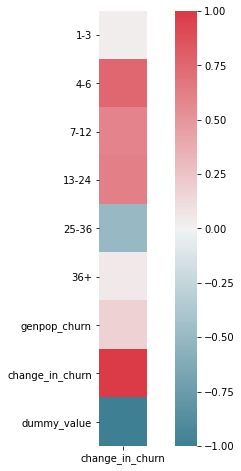

In [123]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

# Write to S3/SF

In [46]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [47]:
import boto3
import io

def to_s3(filename, output_bucket, content):
    client = boto3.client('s3')
    client.put_object(Bucket=output_bucket, Key=filename, Body=content)
    
output_bucket = 'hbo-outbound-datascience-content-dev'
s3 = boto3.resource('s3')
bucket = s3.Bucket(output_bucket)

def write_to_sf(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'title_hours_viewed_retention/{}.csv'.format(file_name)
    to_s3(filename, output_bucket, content)

In [89]:
data.to_csv('daily_monthly_retention_value.csv')

In [88]:
write_to_sf(data, 'daily_monthly_retention_value')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [90]:
output_bucket+'/title_hours_viewed_retention/{}.csv'.format('daily_monthly_retention_value')

'hbo-outbound-datascience-content-dev/title_hours_viewed_retention/daily_monthly_retention_value.csv'

In [57]:
data[(data['title_id'] == 'GYbzrRAvf-ZPCKQEAAAAX')]

,title_name,title_id,season_number,genre,medal,offering_start_date,request_date,days_on_hbo_max,change_in_churn,date_month
438360,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,0,other,Platinum,2022-01-01,2022-01-01,0,-0.000788,2022-01
438361,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,0,other,Platinum,2022-01-01,2022-01-02,1,-0.000788,2022-01
438362,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,0,other,Platinum,2022-01-01,2022-01-03,2,-0.000788,2022-01
438363,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,0,other,Platinum,2022-01-01,2022-01-04,3,-0.000788,2022-01
438364,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,0,other,Platinum,2022-01-01,2022-01-05,4,-0.000788,2022-01
...,...,...,...,...,...,...,...,...,...,...
2619965,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,0,other,Platinum,2022-01-01,2023-02-25,420,-0.000046,2023-02
2619966,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,0,other,Platinum,2022-01-01,2023-02-26,421,-0.000046,2023-02
2619967,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,0,other,Platinum,2022-01-01,2023-02-27,422,-0.000045,2023-02
2619968,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,0,other,Platinum,2022-01-01,2023-02-28,423,-0.000045,2023-02


In [56]:
data[data['date_month'] == '2022-12'].groupby(['title_name', 'title_id', 'season_number']).sum().reset_index()\
.sort_values(by = ['change_in_churn']).head(20)

,title_name,title_id,season_number,days_on_hbo_max,change_in_churn
502,Euphoria,GXKN_xQX5csPDwwEAAABj,2,10540,-0.008531
742,House of the Dragon,GYsYeoAxKH8LCwgEAAAOR,1,3596,-0.003057
785,Injustice,GYbvoqgoeYawYwwEAAAAN,0,10323,-0.002646
856,Kong: Skull Island,GX-nzMwc-EaCFpgEAAAMh,0,22134,-0.002619
694,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,0,10819,-0.002506
1515,The Batman,GYiDbSAmIpMNvYAEAAAAI,0,7502,-0.002218
570,Free Guy,GYdYmPQZFO7eZGAEAAAAT,0,9176,-0.002047
1671,The King's Man,GYeGXugg4ewPCwgEAABi1,0,9331,-0.001959
579,Friends,GXdbR_gOXWJuAuwEAACVH,5,28923,-0.001759
578,Friends,GXdbR_gOXWJuAuwEAACVH,4,28923,-0.001702
